# Gausian Process Regression with Covariance Product and Sum

The atmospheric  CO2 concentration readings in parts per million (ppm)
by volume from air samples are collected continuously by the
Mauno Loa observatory in Hawaii. The data are freely available at
ftp: // ftp.cmdl.noaa.gov/ccg/co2/trends/.
http://scrippsco2.ucsd.edu/data/atmospheric_co2/mlo

This example was first presented in the book of Rasmussen & Williams [^1] and
serves as a tutorial for kernel composition, see for instance
- https://docs.pymc.io/notebooks/GP-MaunaLoa.html
- https://scikit-learn.org/stable/auto_examples/gaussian_process/plot_gpr_co2.html
- http://dfm.io/george/current/user/hyper/

The modelling and the SDE representation of Arno Solin and Simo Särkkä [^2], which
differs from the book of Rasmussen & Williams [^1], is used here.

[1]: Rasmussen, C. E. & Williams, C. K. I. (2006),
     Gaussian Processes for Machine Learning , MIT Press

[2]: Arno Solin and Simo Särkkä (2014).
     Explicit link between periodic covariance functions and state space models.
     In Proceedings of the Seventeenth International Conference on Artifcial
     Intelligence and Statistics (AISTATS 2014). JMLR: W&CP, volume 33.


In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from pysip.regressors import Regressor
from pysip.statespace import Matern32, Matern52, Periodic

## Load and prepare the Mauna Loa CO2 data set

In [2]:
df = pd.read_csv(
    "../../data/mauna_loa/monthly_in_situ_co2_mlo.csv",
    comment='"',
    header=0,
    skipinitialspace=True,
)

df = df[["Date.1", "CO2"]].set_index("Date.1")
df.index.name = "Date"
df = df[df.CO2 != -99.99]

# Use data until 2010 for the fit and the rest for the prediction
C02_mean = df["CO2"].mean()
df["CO2_fit"] = df["CO2"] - C02_mean
df["CO2_pred"] = df["CO2_fit"]
df["CO2_pred"][df.index >= 2010] = np.nan

## Initialize parameters and models

In [3]:
# Matérn 5/2 for slow rising trend (long-term effects)
p1 = [
    dict(name="mscale", value=2.295e03, transform="log"),
    dict(name="lscale", value=4.864e02, transform="log"),
    dict(name="sigv", value=2.210e-01, transform="log"),
]

# Periodic * Matérn 3/2 for quasi-periodic variations
p2 = [
    dict(name="period", value=1.0, transform="fixed"),
    dict(name="mscale", value=2.833e00, transform="log"),
    dict(name="lscale", value=1.341e00, transform="log"),
    dict(name="sigv", value=0.0, transform="fixed"),
]

p3 = [
    dict(name="mscale", value=1.0, transform="fixed"),
    dict(name="lscale", value=2.607e02, transform="log"),
    dict(name="sigv", value=0.0, transform="fixed"),
]

# Matérn 3/2 for short-term effects
p4 = [
    dict(name="mscale", value=4.595e-01, transform="log"),
    dict(name="lscale", value=6.359e-01, transform="log"),
    dict(name="sigv", value=0.0, transform="fixed"),
]

k1 = Matern52(p1, name="k1")
k2 = Periodic(p2, name="k2")
k3 = Matern32(p3, name="k3")
k4 = Matern32(p4, name="k4")

# Compose covariance function
K = k1 + k2 * k3 + k4
K

GPSum(hold_order=0, method='mfd', name='k1__+__k2__x__k3__+__k4')

## Initialize the regressor

In [4]:
reg = Regressor(K, outputs="CO2_fit")

## Do the frequentist fit

In [5]:
fit_summary, corr_matrix, opt_summary = reg.fit(df=df)
fit_summary

         Current function value: 219.930583
         Iterations: 15
         Function evaluations: 805
         Gradient evaluations: 47


,θ,σ(θ),pvalue,|g(η)|,|dpen(θ)|
mscale,2125.040760,1.920489,0.000000e+00,14.449936,2.214448e-23
lscale,486.442797,0.647524,0.000000e+00,2.174267,4.226068e-22
sigv,0.222709,0.009100,0.000000e+00,0.152238,2.016158e-15
mscale,2.296255,0.738407,1.941411e-03,0.036072,1.896530e-17
lscale,1.179341,0.183134,2.104139e-10,0.027030,7.189877e-17
lscale,223.823639,67.750531,9.984063e-04,0.005218,1.996127e-21
mscale,0.442409,0.037335,0.000000e+00,0.075397,5.109184e-16
lscale,0.596159,0.088510,3.194245e-11,0.005384,2.813687e-16


In [8]:
tnew = np.arange(1958, 2030, 0.01)
ds = reg.predict(df=df, smooth=True, tnew=tnew)

Text(38.347222222222214, 0.5, 'CO2 [ppm]')

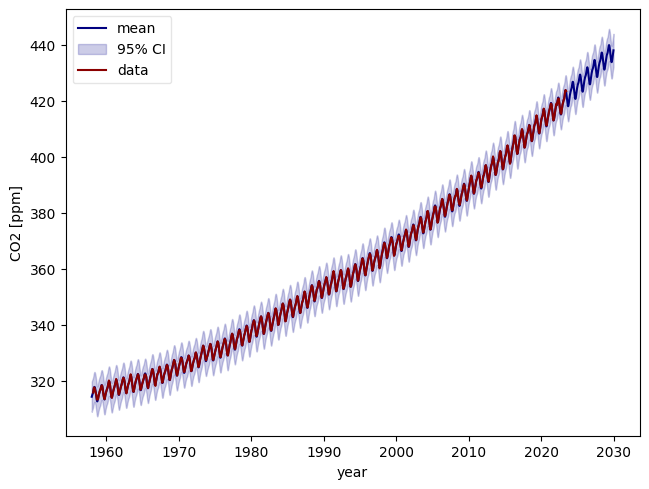

In [9]:
# Plot output mean and 95% credible intervals
ym = ds["y_mean"].sel(outputs="CO2_fit")
ysd = ds["y_std"].sel(outputs="CO2_fit")


plt.plot(tnew, C02_mean + ym, color="navy", label="mean")
plt.fill_between(
    tnew,
    C02_mean + ym - 2 * ysd,
    C02_mean + ym + 2 * ysd,
    color="darkblue",
    alpha=0.2,
    label=r"95% CI",
)
plt.plot(df.index, df["CO2"], color="darkred", label="data")
plt.tight_layout()
plt.legend(loc="best", fancybox=True, framealpha=0.5)
ax = plt.gca()
ax.set_xlabel("year")
ax.set_ylabel("CO2 [ppm]")
